<a href="https://colab.research.google.com/github/mateusz-kacpura/exercises-python/blob/main/Rozszerzenie%20Variational%20Autoencoder%20(VAE)%20do%20generowania%20bardziej%20z%C5%82o%C5%BConych%20danych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - kl_loss: 98.9796 - loss: 35.9067 - reconstruction_loss: 35.8572 - val_kl_loss: 163.2720 - val_loss: 10.7505 - val_reconstruction_loss: 10.6688
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - kl_loss: 157.0405 - loss: 10.0570 - reconstruction_loss: 9.9785 - val_kl_loss: 138.0837 - val_loss: 9.1378 - val_reconstruction_loss: 9.0687
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - kl_loss: 132.3736 - loss: 8.8081 - reconstruction_loss: 8.7419 - val_kl_loss: 116.2040 - val_loss: 8.4872 - val_reconstruction_loss: 8.4291
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - kl_loss: 116.3996 - loss: 8.1879 - reconstruction_loss: 8.1297 - val_kl_loss: 108.0136 - val_loss: 8.1850 - val_reconstruction_loss: 8.1310
Epoch 5/30
469/469 ━━━━━

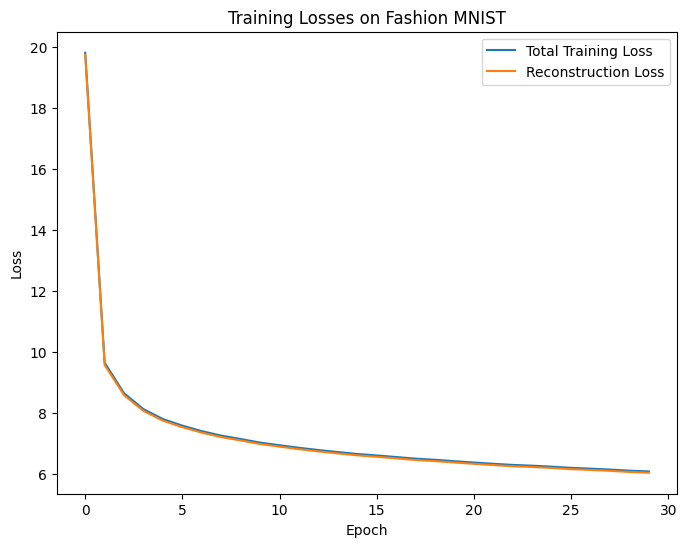

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


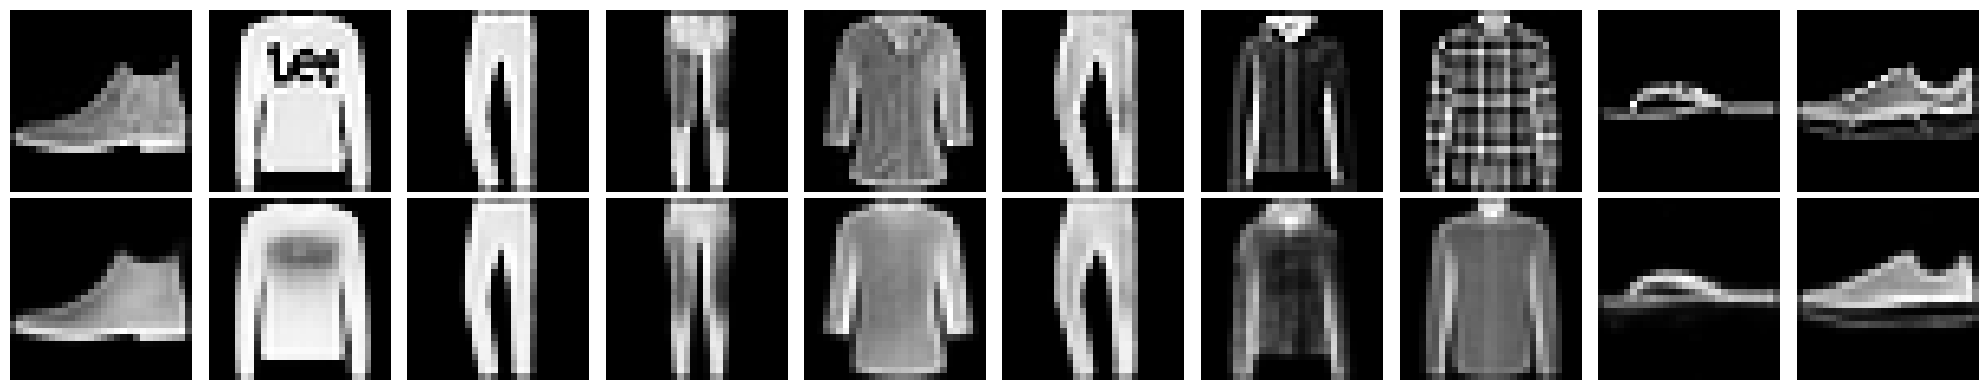

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
x_train_cifar shape: (50000, 32, 32, 3)
x_test_cifar shape: (10000, 32, 32, 3)
Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - kl_loss: 130.9861 - loss: 128.5716 - reconstruction_loss: 128.5061 - val_kl_loss: 594.9145 - val_loss: 59.4751 - val_reconstruction_loss: 59.1777
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - kl_loss: 577.3468 - loss: 52.6690 - reconstruction_loss: 52.3803 - val_kl_loss: 641.2575 - val_loss: 40.8529 - val_reconstruction_loss: 40.5323
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - kl_loss: 619.9548 - loss: 38.3328 - reconstruction_loss: 38.0228 - val_kl_loss: 592.1017 - val_loss: 34.3752 - val_reconstruction_loss: 34.0791
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - kl_loss: 613.6006 - loss: 32.9986 - reconstruction_loss: 32.6918 - val_kl_loss: 619.1593 - val_loss: 30.6206 - val_reconstruction_loss: 30.3110
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - kl_loss: 

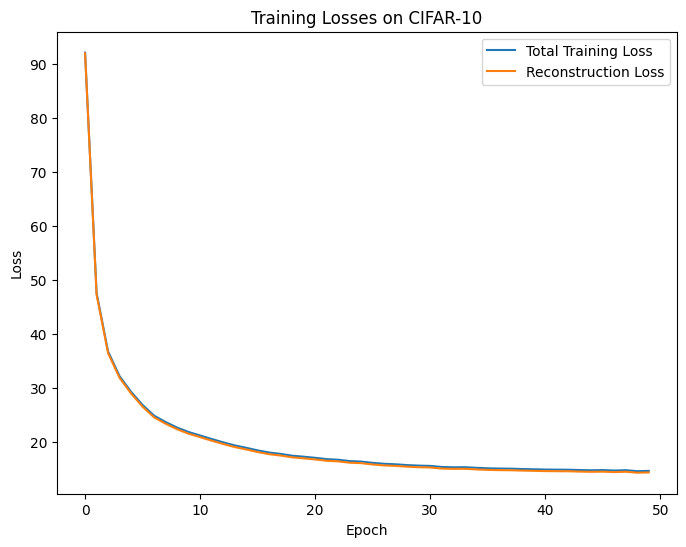

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


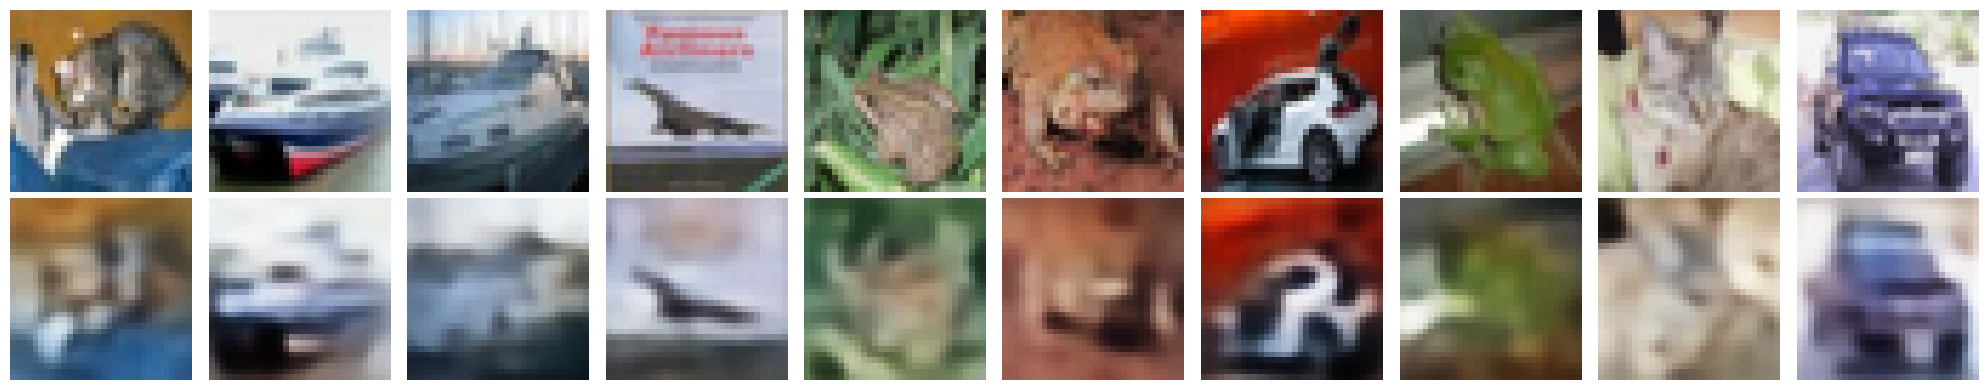

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, BatchNormalization, LeakyReLU, Cropping2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist, cifar10
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Sampling layer for reparameterization trick
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
def build_conv_encoder(input_shape, latent_dim):
    input_img = Input(shape=input_shape)
    x = input_img

    # Compute the number of convolutional layers based on input size
    num_conv_layers = int(np.floor(np.log2(min(input_shape[0], input_shape[1]))) - 2)
    num_conv_layers = max(num_conv_layers, 1)  # Ensure at least one layer
    conv_filters = [32, 64, 128, 256][:num_conv_layers]

    for filters in conv_filters:
        x = Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

    x_shape = tf.keras.backend.int_shape(x)[1:]  # Save shape before flattening
    x = Flatten()(x)
    x = Dense(512)(x)
    x = LeakyReLU()(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    return encoder, x_shape, num_conv_layers

# Decoder
def build_conv_decoder(x_shape, latent_dim, output_shape, num_conv_layers):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(512)(latent_inputs)
    x = LeakyReLU()(x)
    x = Dense(np.prod(x_shape))(x)
    x = LeakyReLU()(x)
    x = Reshape(x_shape)(x)

    conv_filters = [256, 128, 64, 32][:num_conv_layers][::-1]

    for filters in conv_filters:
        x = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

    # Final convolution to match the output shape
    x = Conv2DTranspose(
        output_shape[2],
        kernel_size=3,
        strides=1,
        activation='sigmoid',  # Use 'sigmoid' activation since data is in [0, 1]
        padding='same'
    )(x)

    # Adjust the output size to match the input size
    target_height, target_width = output_shape[0], output_shape[1]
    final_height, final_width = tf.keras.backend.int_shape(x)[1], tf.keras.backend.int_shape(x)[2]
    diff_height = final_height - target_height
    diff_width = final_width - target_width

    # If the output size is larger than the input, crop it
    if diff_height > 0 or diff_width > 0:
        cropping = (
            (diff_height // 2, diff_height - diff_height // 2),
            (diff_width // 2, diff_width - diff_width // 2)
        )
        x = Cropping2D(cropping=cropping)(x)
    # If the output size is smaller than the input, pad it
    elif diff_height < 0 or diff_width < 0:
        padding = (
            (-diff_height // 2, -diff_height - (-diff_height // 2)),
            (-diff_width // 2, -diff_width - (-diff_width // 2))
        )
        x = ZeroPadding2D(padding=padding)(x)

    decoder = Model(latent_inputs, x, name='decoder')
    return decoder

# VAE class
class VAE(Model):
    def __init__(self, encoder, decoder, kl_weight=0.0005, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Compute reconstruction loss using raw Tensor operations
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.math.squared_difference(data, reconstruction),
                    axis=[1, 2, 3]
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            # Total loss
            total_loss = reconstruction_loss + self.kl_weight * kl_loss
        # Gradients and optimization step
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.math.squared_difference(data, reconstruction),
                axis=[1, 2, 3]
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )
        total_loss = reconstruction_loss + self.kl_weight * kl_loss
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        # For prediction and encoding
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

# Function to train the VAE
def train_vae(input_shape, latent_dim, x_train, x_val, epochs=30, batch_size=128, dataset_name='Dataset'):
    encoder, x_shape, num_conv_layers = build_conv_encoder(input_shape, latent_dim)
    decoder = build_conv_decoder(x_shape, latent_dim, input_shape, num_conv_layers)
    vae = VAE(encoder, decoder, kl_weight=0.0005)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    history = vae.fit(
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val,)
    )
    # Plot training losses
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Total Training Loss')
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training Losses on {dataset_name}')
    plt.show()
    # Reconstruct validation images
    x_reconstructed = vae.predict(x_val[:10])
    # Plot original and reconstructed images
    plot_reconstructions(x_val[:10], x_reconstructed, input_shape)
    return vae

# Function to plot reconstructions
def plot_reconstructions(x_original, x_reconstructed, input_shape, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        if input_shape[-1] == 1:
            plt.imshow(x_original[i].squeeze(), cmap='gray')
        else:
            plt.imshow(x_original[i])
        ax.axis('off')
        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        if input_shape[-1] == 1:
            plt.imshow(x_reconstructed[i].squeeze(), cmap='gray')
        else:
            plt.imshow(x_reconstructed[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load and preprocess Fashion MNIST data
(x_train_fashion, _), (x_test_fashion, _) = fashion_mnist.load_data()
x_train_fashion = x_train_fashion.astype('float32') / 255.
x_test_fashion = x_test_fashion.astype('float32') / 255.
x_train_fashion = np.expand_dims(x_train_fashion, -1)  # (60000, 28, 28, 1)
x_test_fashion = np.expand_dims(x_test_fashion, -1)    # (10000, 28, 28, 1)

# Train VAE on Fashion MNIST
vae_fashion = train_vae(
    input_shape=(28, 28, 1),
    latent_dim=16,
    x_train=x_train_fashion,
    x_val=x_test_fashion,
    epochs=30,
    batch_size=128,
    dataset_name='Fashion MNIST'
)

# Load and preprocess CIFAR-10 data
(x_train_cifar, _), (x_test_cifar, _) = cifar10.load_data()
x_train_cifar = x_train_cifar.astype('float32') / 255.
x_test_cifar = x_test_cifar.astype('float32') / 255.

print(f"x_train_cifar shape: {x_train_cifar.shape}")  # (50000, 32, 32, 3)
print(f"x_test_cifar shape: {x_test_cifar.shape}")    # (10000, 32, 32, 3)

# Train VAE on CIFAR-10
vae_cifar = train_vae(
    input_shape=(32, 32, 3),
    latent_dim=128,
    x_train=x_train_cifar,
    x_val=x_test_cifar,
    epochs=50,
    batch_size=256,
    dataset_name='CIFAR-10'
)





Pobieranie pliku ZIP z Google Drive: https://drive.google.com/uc?id=1A2dNWabg6_um-V3lhw1tyead5hCpjaW8...


Downloading...
From (original): https://drive.google.com/uc?id=1A2dNWabg6_um-V3lhw1tyead5hCpjaW8
From (redirected): https://drive.google.com/uc?id=1A2dNWabg6_um-V3lhw1tyead5hCpjaW8&confirm=t&uuid=79339504-51a1-4a8a-97bc-c9105c6e621f
To: /content/image.zip
100%|██████████| 2.73G/2.73G [01:02<00:00, 43.9MB/s]


Rozpakowywanie pliku ZIP: /content/image.zip do /content/images...
Rozpakowywanie zakończone!
x_celeba shape: (30000, 64, 64, 3)
x_celeba shape: (21000, 64, 64, 3)
x_val_celeba shape: (9000, 64, 64, 3)
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 60s 232ms/step - kl_loss: 15503.8574 - loss: 5168.7778 - reconstruction_loss: 5161.0259 - val_kl_loss: 585.3336 - val_loss: 4353.9053 - val_reconstruction_loss: 4353.6123
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - kl_loss: 428.6235 - loss: 4360.9814 - reconstruction_loss: 4360.7676 - val_kl_loss: 10122.0000 - val_loss: 4358.6729 - val_reconstruction_loss: 4353.6123
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 40s 151ms/step - kl_loss: 3084.5154 - loss: 4209.8618 - reconstruction_loss: 4208.3203 - val_kl_loss: 1157.1160 - val_loss: 3480.7727 - val_reconstruction_loss: 3480.1931
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 155ms/step - kl_loss: 1166.2006 - loss: 3410.0283 - reconstruction_loss: 3409.4463 - val_kl_loss: 1388.7516 - val_los

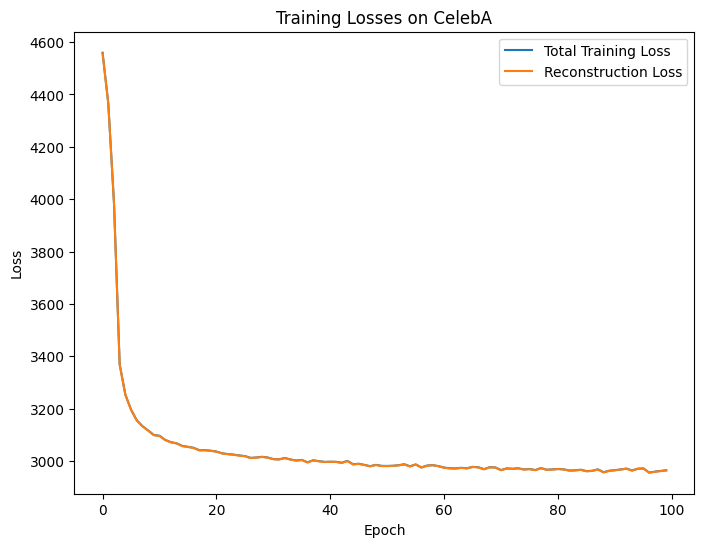

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


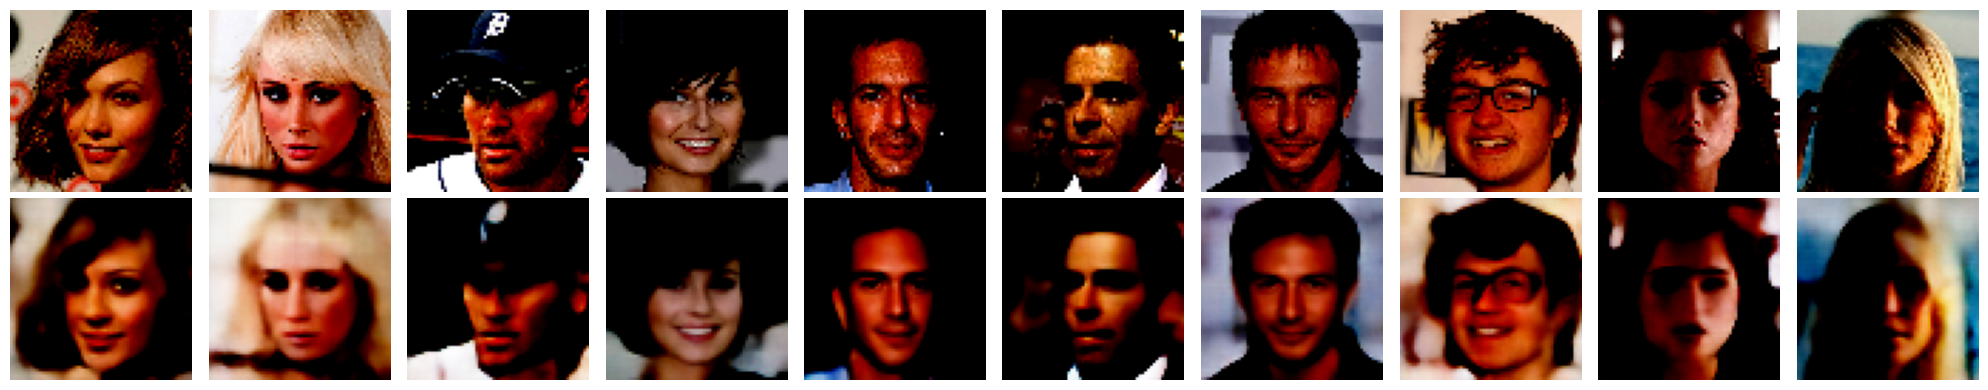

In [2]:
import zipfile
import gdown  # Biblioteka do pobierania plików z Google Drive

# Bezpośredni link do pliku ZIP
file_id = '1A2dNWabg6_um-V3lhw1tyead5hCpjaW8'
zip_url = f'https://drive.google.com/uc?id={file_id}'

# Ścieżka do pobranego pliku ZIP i lokalizacja rozpakowania
zip_path = '/content/image.zip'
local_extract_path = '/content/images'

# Pobieranie pliku ZIP
if not os.path.exists(zip_path):  # Sprawdzanie, czy plik ZIP już istnieje
    print(f"Pobieranie pliku ZIP z Google Drive: {zip_url}...")
    gdown.download(zip_url, zip_path, quiet=False)
else:
    print(f"Plik ZIP już istnieje: {zip_path}")

# Rozpakowanie archiwum
if not os.path.exists(local_extract_path):  # Sprawdzanie, czy katalog już istnieje
    os.makedirs(local_extract_path)  # Tworzenie katalogu, jeśli nie istnieje
    print(f"Rozpakowywanie pliku ZIP: {zip_path} do {local_extract_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(local_extract_path)
    print("Rozpakowywanie zakończone!")
else:
    print(f"Katalog docelowy już istnieje: {local_extract_path}")

import zipfile  # Dodano moduł zipfile

# Path to CelebA images
celeba_path = '/content/images/image'  # Update this path as needed

def load_celeba_images(path, img_size=(64, 64)):
    image_paths = glob.glob(os.path.join(path, '*.jpg'))
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.
        images.append(img)
    return np.array(images)

# Load CelebA data
x_celeba = load_celeba_images(celeba_path)
x_celeba = (x_celeba - 0.5) * 2 # normalizacja danych
print(f"x_celeba shape: {x_celeba.shape}")  # e.g., (30000, 64, 64, 3)

# Split into training and validation sets
x_train_celeba, x_val_celeba = train_test_split(x_celeba, test_size=0.3, random_state=42)

print(f"x_celeba shape: {x_train_celeba.shape}")  # Oczekiwany kształt: (num_samples, 64, 64, 3)
print(f"x_val_celeba shape: {x_val_celeba.shape}")

# Trenowanie VAE na CelebA
vae_celeba = train_vae(
    input_shape=(64, 64, 3),
    latent_dim=256,
    x_train=x_train_celeba,
    x_val=x_val_celeba,
    epochs=100,
    batch_size=128,
    dataset_name='CelebA'
)